In [1]:
using LinearAlgebra
using Combinatorics
using Plots
using HDF5

Trace distance:

$D(\rho_1, \rho_2) = \frac{1}{2} \operatorname{Tr}|\rho_1 - \rho_2|$,

where $|A| = \sqrt{A^\dagger A}$

Non-Markovianity:

(H.-P. Breuer, E.-M. Laine, J. Piilo, "Measure for the Degree of Non-Markovian Behavior of Quantum Processes in Open Systems," Physical Review Letters, 2009.)

$\sigma = \frac{dD}{dt}$

$ \mathcal{N} = \max_{\rho_1(0), \rho_2(0)}{\int_{\sigma>0}{\sigma dt}} $

In [2]:
function read_timeevolution(state, γ)

    file_name = "../DATA/ALL_GAMMAS_B4_D10.h5"

    h5open(file_name, "r") do file
        ρᵧ = read(file[state][string(γ)])
        t = ρᵧ["t"]
        ρ₀₀ = ρᵧ["p0"]; Re_ρ₀₁ = ρᵧ["s_re"];  Im_ρ₀₁ = ρᵧ["s_im"]
        ρ_series = []
        t_series = []

        for i in 1:length(t)
            ρᵢ= [ ρ₀₀[i]                      Re_ρ₀₁[i] + im * Im_ρ₀₁[i]
                  Re_ρ₀₁[i] - im * Im_ρ₀₁[i]  1 - ρ₀₀[i]                 ]
            push!(ρ_series, convert(Matrix{ComplexF64}, ρᵢ))
            push!(t_series, convert(Float64, t[i]))
        end
        return(ρ_series, t_series)
    end
end

read_timeevolution (generic function with 1 method)

In [3]:
function TrDist(ρ₁, ρ₂)
    A = ρ₁-ρ₂
    D = tr(sqrt(A'*A))/2
    if abs(imag(D))>1e-6
        throw(DomainError(D, "Trace distance is complex number"))
    else
        return(real(D))
    end
end    

ρ₁ = [1 im
      -im 0]

ρ₂ = [.99 im
      -im .01]      

TrDist(ρ₁, ρ₂)

0.010000000000000005

In [4]:
function NonMarkovianityBasis(γᵢ)
    N=[]
    for (i,j)  in combinations(1:4, 2)
        ρs₁, t₁ = read_timeevolution(state[i],γᵢ)
        ρs₂, t₂ = read_timeevolution(state[j],γᵢ)
        dD = diff([TrDist(ρ₁, ρ₂) for (ρ₁, ρ₂) in zip(ρs₁, ρs₂)])
        append!(N,sum(dD[dD.>0]))
    end
    maximum(N)
end   

NonMarkovianityBasis (generic function with 1 method)

In [5]:
function NonMarkovianity(states, γᵢ)
    N=[]
    for (i,j)  in combinations(1:length(states), 2)
        ρs₁, t₁ = read_timeevolution(states[i],γᵢ)
        ρs₂, t₂ = read_timeevolution(states[j],γᵢ)
        dD = diff([TrDist(ρ₁, ρ₂) for (ρ₁, ρ₂) in zip(ρs₁, ρs₂)])
        append!(N, sum(dD[dD.>0]))
    end
    maximum(N)
end  

NonMarkovianity (generic function with 1 method)

In [19]:
using StatsPlots

function NonMarkovianityViolins(states, γ_list)
    N_list = []
    sum_dD_pos_all = []

    for γᵢ in γ_list
        N = []
        sum_dD_pos = []  # To store sum(dD_pos) for each combination

        for (i, j) in combinations(1:length(states), 2)
            ρs₁, t₁ = read_timeevolution(states[i], γᵢ)
            ρs₂, t₂ = read_timeevolution(states[j], γᵢ)
            dD = diff([TrDist(ρ₁, ρ₂) for (ρ₁, ρ₂) in zip(ρs₁, ρs₂)])
            dD_pos = dD[dD .> 0]
            push!(sum_dD_pos, sum(dD_pos))
            append!(N, sum(dD_pos))
        end

        push!(sum_dD_pos_all, (sum_dD_pos, γᵢ))
        push!(N_list, maximum(N))
    end

    # Prepare data for violin plot
    flattened_sum_dD_pos = []
    labels = []
    
    for (sum_dD_pos, γᵢ) in sum_dD_pos_all
        append!(flattened_sum_dD_pos, sum_dD_pos)
        append!(labels, fill("γ=$γᵢ", length(sum_dD_pos)))
    end

    # Plot the violin plots for each gamma on one plot
    violin(labels, flattened_sum_dD_pos, legend=false, xlabel="Gamma", ylabel="Sum(dD > 0)", title="Violin Plot of Sum(dD[dD .> 0]) for Different Gammas")

    #N_list
end

NonMarkovianityViolins (generic function with 1 method)

In [20]:
dodeca_10_states = ["D"*string(n) for n=1:10];
basis_states = ["B"*string(n) for n=1:4];

all_states = vcat(basis_states, dodeca_10_states);

In [7]:
γ = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133", "79.477", "251.33"]

NonMarkovianity(all_states[1:3], γ[end])

0.0006399448334512003

In [8]:
N = [NonMarkovianity(all_states, γᵢ) for γᵢ in γ]

8-element Vector{Float64}:
 0.00015420954551698118
 0.012929146711576078
 5.91358315071705e-5
 0.0007101884113623752
 0.03463243512167516
 0.04187746492180401
 0.003017747776987354
 0.0006399448334512003

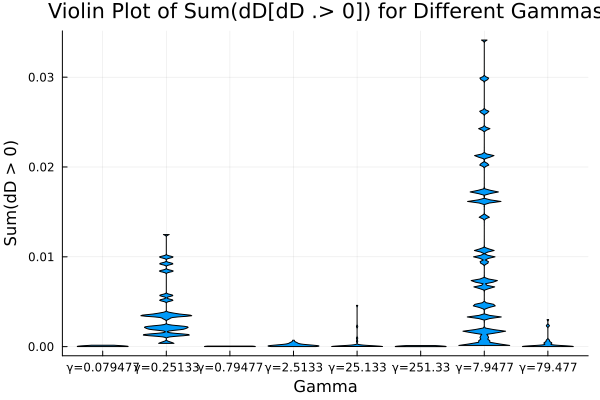

In [21]:
NonMarkovianityViolins(dodeca_10_states, γ)

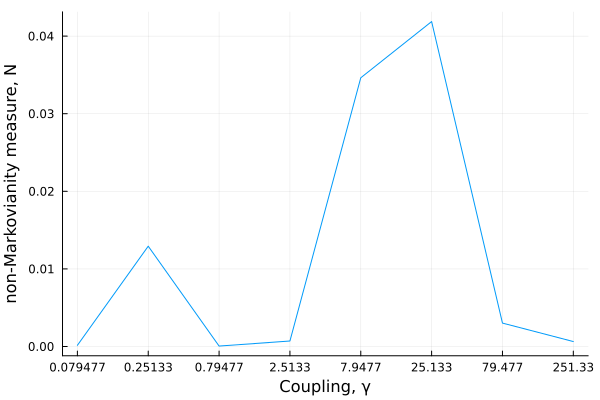

In [23]:
plot(N, xticks = (1:length(γ), γ), legend = false)
#title!("Breuer Non-Markovianity Measure")
xlabel!("Coupling, γ")
ylabel!("non-Markovianity measure, N")
#savefig("NonMarkovianity.png")

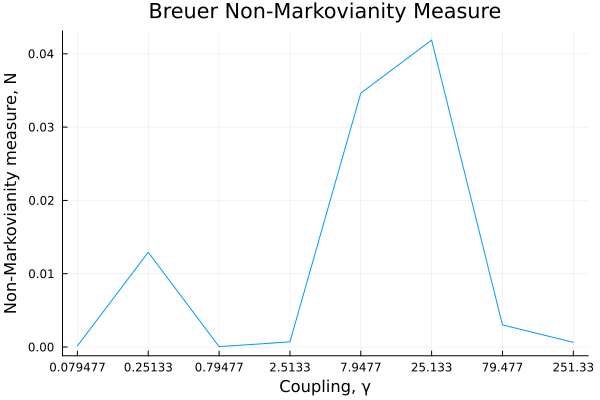

In [13]:
# Plot the data
plot(N, xticks=(1:length(γ), γ), legend=false)

# Set labels
xlabel!("Coupling, γ")
ylabel!("Non-Markovianity measure, N")

# Optionally set a title
title!("Breuer Non-Markovianity Measure")

# Save the figure to a file
#savefig("NonMarkovianity.png")




In [11]:
using PyCall

# Import the pickle module from Python
pickle = pyimport("pickle")

# Use Python's built-in open function to open the file in binary write mode
pyopen = pyimport("builtins").open

# Open a file in write-binary mode using Python's open function
file = pyopen("NonMark12.pkl", "wb")

# Use pickle's dump function to save the array
pickle.dump(NaN16, file)

# Close the file
file.close()